In [1]:
import pandas as pd
import seaborn as sns
sns.set()

In [2]:
df = pd.read_csv(r"C:\Users\mnikolyuk001\Downloads\RTSI_000101_240119 (1).txt", delimiter = ",")
df['date'] = pd.to_datetime(df['<DATE>'], dayfirst = True)
df = df[['date','<CLOSE>']].rename({'<CLOSE>':'price'}, axis = 1)
df.index = df['date']
df.drop('date', axis = 1, inplace = True)

C:\Users\MNIKOL~1\AppData\Local\Temp/ipykernel_16912/3725995923.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['<DATE>'], dayfirst = True)


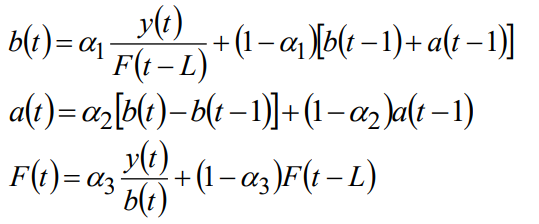

In [29]:
def init_trend(series, N):
    sum = 0.0
    for i in range(N):
        sum += float(series[i+N] - series[i]) / N
    return sum / N

def init_seasonal_components(series, N):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/N)
    # Средние в сезоне
    for j in range(n_seasons):
        season_averages.append(sum(series[N*j:N*j+N])/float(N))
    for i in range(N):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[N*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def HoltWinters(series, N, a1, a2, a3, n_preds):
    result = []
    seasonals = init_seasonal_components(series, N)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = init_trend(series, N)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%N])
        else:
            val = series[i]
            last_smooth, smooth = smooth, a1*(val-seasonals[i%N]) + (1-a1)*(smooth+trend)
            trend = a2 * (smooth-last_smooth) + (1-a2)*trend
            seasonals[i%N] = a3*(val-smooth) + (1-a3)*seasonals[i%N]
            result.append(smooth+trend+seasonals[i%N])
    return result

<AxesSubplot:title={'center':'CAC цена'}, xlabel='date'>

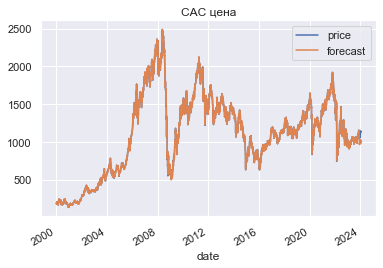

In [30]:
df.plot(title="CAC цена")

In [50]:
season = 26
N = season*2
train = df.iloc[0:df.shape[0]-N]

In [97]:
forecast = HoltWinters(train['price'], season, 0.005, 0.5, 0.5, N)
df['forecast'] = forecast
len(forecast) - len(df['price'])

0

<AxesSubplot:title={'center':'Факт-прогноз'}, xlabel='date'>

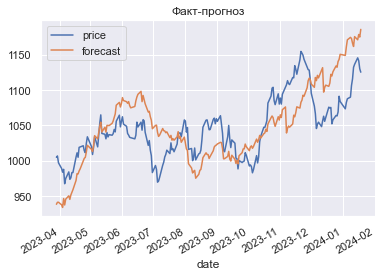

In [98]:
df.iloc[-N*4:-1].plot(title = 'Факт-прогноз')